# Homework 2 (66 pts)

## Overview
This homework will focus on checking the global and local spatial autocorrelation and point pattern analysis based on the Airbnb listing in New York City and the underlying socioeconomics. Through this practice, you will review the process of retrieving data from API, building spatial weights from georeferenced data, checking global and local spatial autocorrelation, and conducting point pattern analysis. 

## Grading
Each exercise will be graded based on the following rubrics:
- 2 points. Completed the task, presented the expected results, and codes were well documented and explained.
- 1 point. Completed the task with some disparity from the expected results.
- 0 point. Did not complete the excercise.

## Late submission policy
For late submission, every extra day after the due date will lead to 20% off of your points. Less than a day will be counted as one day. All submissions after the TA team posts the answers will not be accepted.

## 1. Read and Clean Data
### 1.1 Read and Clean Census Tract Data (4 pts)
Homework 1 presented detailed steps of downloading and cleaning census tract data while here you can try Socrata to retrieve the same dataset. Use the following link: https://data.cityofnewyork.us/City-Government/2020-Census-Tracts-Tabular/63ge-mke6 and find the API Endpoint. 
- Specify the BoroName as Manhattan in the url. (2 pts)
- Transform the downloaded dataframe into a geodataframe and set the crs as 4326. (2 pts)

Present the geodataframe (name it as **ct**).

In [99]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import shape
from shapely.geometry import Polygon
import contextily as cx
import rioxarray
from pysal.lib import cg as geometry
from pysal.lib import weights
import warnings
import pysal
warnings.filterwarnings("ignore")

os.getcwd()

'C:\\Users\\muwen\\Downloads\\4680_5680_intro_uds-main\\4680_5680_intro_uds-main\\Homework'

In [21]:
ct = pd.read_json('https://data.cityofnewyork.us/resource/63ge-mke6.json?boroname=Manhattan')

<AxesSubplot: >

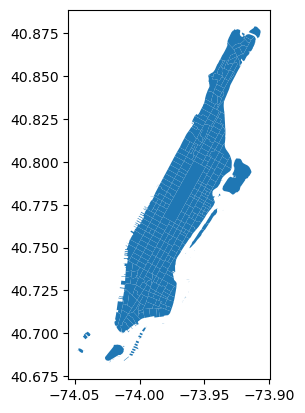

In [41]:
ct['the_geom'] = ct['the_geom'].apply(shape)
ct = gpd.GeoDataFrame(ct, geometry='the_geom')
ct = ct.set_crs(epsg=4326)
ct.plot()

### 1.2 Read and Clean Airbnb Listing Data (2 pts)
Similar to homework 1, you are required to download and clean the Airbnb listing data and wrap all of them into one cell. Use the same link in homework 1 to download the listing data in New York City.
- Change *price* column type as float.
- Transform the dataframe into geodataframe using the latitude-longitude pairs.
- Spatial join **ct** with only *geoid*, *boroname* and *the_geom* columns to the listing geodataframe.

You should only have the listings in Manhattan. Present your geodataframe **listing** below.

In [81]:
listing_raw = pd.read_csv("http://data.insideairbnb.com/united-states/ny/new-york-city/2022-12-04/data/listings.csv.gz")

#remove NaN in beds
listing_s = listing_g[listing_g['beds'].isna()==False]
#drop columns
listing_s = listing_s.drop(columns=['bathrooms', 'calendar_updated', 'license', 'neighbourhood'])

#remove dollar sign and comma
listing_raw['price'] = listing_raw['price'].str.replace('$', "")
listing_raw['price'] = listing_raw['price'].str.replace(',', "")
#transforme into float
listing_raw['price'] = listing_raw['price'].astype(float)

geometry = gpd.points_from_xy(listing_raw['longitude'], listing_raw['latitude'])
listing_g = gpd.GeoDataFrame(listing_raw, geometry=geometry, crs='EPSG:4326')

listing = gpd.tools.sjoin(listing_g, ct[['geoid', 'boroname', 'the_geom']], how="left")
listing.info()

C:\Users\muwen\AppData\Local\Temp\ipykernel_26744\157907363.py:1: DtypeWarning: Columns (68) have mixed types. Specify dtype option on import or set low_memory=False.
  listing_raw = pd.read_csv("http://data.insideairbnb.com/united-states/ny/new-york-city/2022-12-04/data/listings.csv.gz")
C:\Users\muwen\AppData\Local\Temp\ipykernel_26744\157907363.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  listing_raw['price'] = listing_raw['price'].str.replace('$', "")


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 41533 entries, 0 to 41532
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   id                                            41533 non-null  int64   
 1   listing_url                                   41533 non-null  object  
 2   scrape_id                                     41533 non-null  int64   
 3   last_scraped                                  41533 non-null  object  
 4   source                                        41533 non-null  object  
 5   name                                          41520 non-null  object  
 6   description                                   40747 non-null  object  
 7   neighborhood_overview                         24089 non-null  object  
 8   picture_url                                   41533 non-null  object  
 9   host_id                                   

### 1.3 Retrieve American Community Survey (ACS) Data (6 pts)
The 3rd dataset is from American Community Survey. You can first check with "2019 ACS Table List" from [ACS table](https://www.census.gov/programs-surveys/acs/technical-documentation/table-shells.2019.html#list-tab-LO1F1MU1CQP3YOHD2T) and find the median household income code as **B19013_001**. Use *cenpy* module to download the household income information in New York City and use census tract level as the geographic unit. Save the data as **acs_data** and name the column for household income as *median_hh_inc*. Present the information of **acs_data**. (2 pts)

In [48]:
import cenpy 

In [64]:
acs_cp = cenpy.products.ACS()
acs_cp_data = acs_cp.from_place('New York, NY',
                                level='tract',
                                variables=['B19013_001'])
acs_data = acs_cp_data.rename(columns={'B19013_001E':'median_hh_inc'})
acs_data.info()

Matched: New York, NY to New York city within layer Incorporated Places
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2066 entries, 0 to 2065
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   GEOID          2066 non-null   object  
 1   geometry       2066 non-null   geometry
 2   median_hh_inc  2006 non-null   float64 
 3   state          2066 non-null   object  
 4   county         2066 non-null   object  
 5   tract          2066 non-null   object  
dtypes: float64(1), geometry(1), object(4)
memory usage: 113.0+ KB


C:\Users\muwen\AppData\Local\Temp\ipykernel_26744\1223319537.py:2: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  acs_cp_data = acs_cp.from_place('New York, NY',


Notice that *median_hh_inc* column includes null values. Replace all null values with the mean of the median household income. (2 pts)

In [65]:
mean_hh_inc = acs_data['median_hh_inc'].mean()
acs_data['median_hh_inc'] = acs_data['median_hh_inc'].fillna(mean_hh_inc)
acs_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2066 entries, 0 to 2065
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   GEOID          2066 non-null   object  
 1   geometry       2066 non-null   geometry
 2   median_hh_inc  2066 non-null   float64 
 3   state          2066 non-null   object  
 4   county         2066 non-null   object  
 5   tract          2066 non-null   object  
dtypes: float64(1), geometry(1), object(4)
memory usage: 113.0+ KB


Plot the median household income by census tract. Five quantiles are used here with *GnBu* color ramp. Remember to add:
- Title
- Legend
- X-Y axis names

properly to the map. (2 pts)

Text(100.09186648400855, 0.5, 'Latitude')

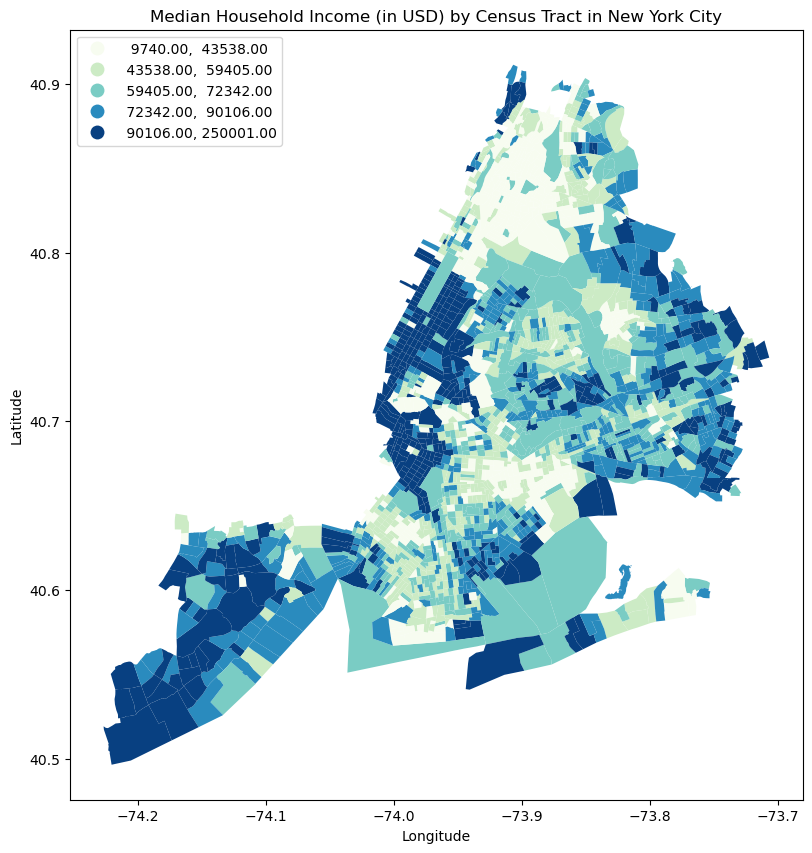

In [103]:
acs_data = acs_data.to_crs(epsg=4326)

f, ax = plt.subplots(1, figsize=(10, 10))
acs_data.plot(ax=ax,
              column='median_hh_inc',
              legend=True,
              scheme= 'Quantiles',
              cmap='GnBu',
              legend_kwds={'loc': 'upper left'})

ax.set_title("Median Household Income (in USD) by Census Tract in New York City")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

## 2. Data Analysis & Visualization
### 2.1 Create Spatial Weights (12 pts)
ACS data is firstly analyzed. Create a spatial weight, *wq*, with *Queen* method and standardize the spatial weight. (2 pts)

In [107]:
wq = weights.contiguity.Queen.from_dataframe(acs_data)
wq.transform = "R"

('WARNING: ', 229, ' is an island (no neighbors)')


Since *median_hh_inc* column will be used repetitively, store this column in variable *y*. Therefore, *ylag* is generated from *y* to store the spatial lags of *median_hh_inc*. (2 pts)

In [118]:
acs_data['y'] = acs_data['median_hh_inc']
acs_data['ylag'] = weights.spatial_lag.lag_spatial(wq, acs_data['y'])

To compare *y* with *ylag* visually, you can create two plots side by side. 
- Both maps should have 5 quantiles of *y* and *ylag* respectively with your choice of color ramp. (2 pts)
- Both maps should have proper titles and legends. (2 pts)
- Remove axis for both maps. (2 pts)

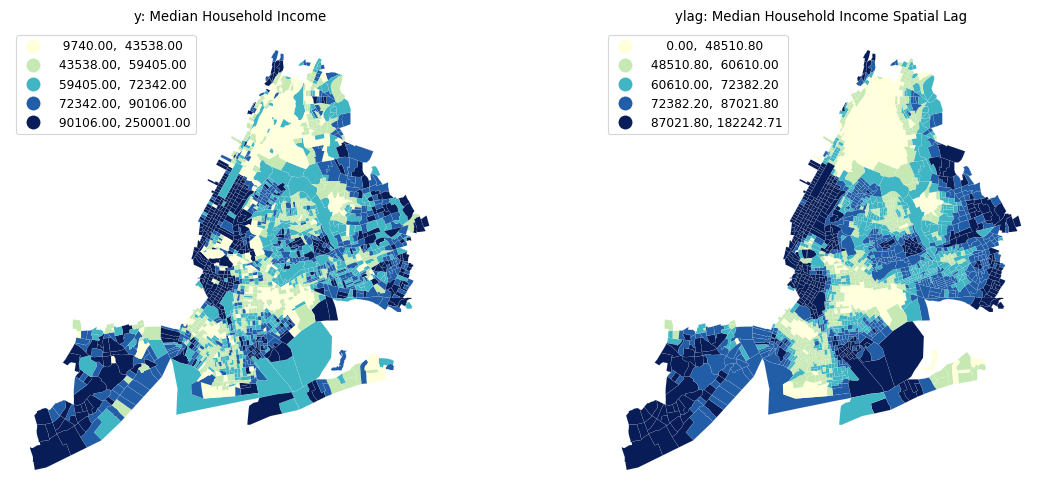

In [143]:
f, ax = plt.subplots(1, 2, figsize=(14, 6))
acs_data.plot("y",
              ax=ax[0],
              legend=True,
              edgecolor="white",
              linewidth=0.05,
              scheme= 'Quantiles',
              cmap='YlGnBu',
              legend_kwds={'loc': 'upper left'})
ax[0].set_axis_off()
ax[0].set_title("y: Median Household Income")

acs_data.plot("ylag", 
              ax=ax[1],
              legend=True,
              edgecolor="white",
              linewidth=0.05,
              scheme= 'Quantiles',
              cmap='YlGnBu',
              legend_kwds={'loc': 'upper left'})
ax[1].set_axis_off()
ax[1].set_title("ylag: Median Household Income Spatial Lag")

plt.show()

Why do the two maps look different? How do you interpret the difference? (2 pts)

The apparent differences between the near neighbors in the left map $y$ (especially Bronx and most of Queens) are reduced in the right map $ylag$. The spatial lag also smoothes out the differences between nearby observations. So the map $ylag$ on the right looks more regular compared to the original map $y$.

### 2.2 Global Spatial Correlation (8 pts)
By plotting median household income above, you will have some ideas about where the affluent and the less affluent people live. To verify your hypothesis, you can try to find how they are correlated with their neighbors globally.

Firstly, create a boolean list *yb* if the census tract's median household income (*y*) exceeds the median median household income in Manhattan (median of *y*). (2 pts)

#### Note: 
Wasn't sure if the question asks for median median household income in Manhattan or median of y, which is the median household income in NYC. So I've calculated for both.

In [159]:
# using median median household income in Manhattan
mn_median = acs_data[acs_data['county']=='061']['y'].median()
mn_median
yb_mn = acs_data['y'] > mn_median
yb_mn

0        True
1       False
2       False
3       False
4        True
        ...  
2061    False
2062    False
2063    False
2064    False
2065     True
Name: y, Length: 2066, dtype: bool

In [161]:
# using median of y
y_median = acs_data['y'].median()
y_median
yb = acs_data['y'] > y_median
yb

0        True
1        True
2       False
3       False
4        True
        ...  
2061     True
2062     True
2063     True
2064     True
2065     True
Name: y, Length: 2066, dtype: bool

Next, create a new column *yb* in **acs_data** where *0 low* means the census tract's median household income is below the median of *y* and *1 high* means the rest. (2 pts)

In [162]:
# using median median household income in Manhattan
acs_data['yb_mn'] = yb_mn.astype(int)
acs_data[["y", "yb_mn"]].head()

,y,yb_mn
0,100543.0,1
1,89273.0,0
2,21250.0,0
3,46118.0,0
4,103825.0,1


In [164]:
# using median of y
acs_data['yb'] = yb.astype(int)
acs_data[["y", "yb"]].head()

,y,yb
0,100543.0,1
1,89273.0,1
2,21250.0,0
3,46118.0,0
4,103825.0,1


Plot census tracts whose household income are above the median as black and those below as white. (2 pts)

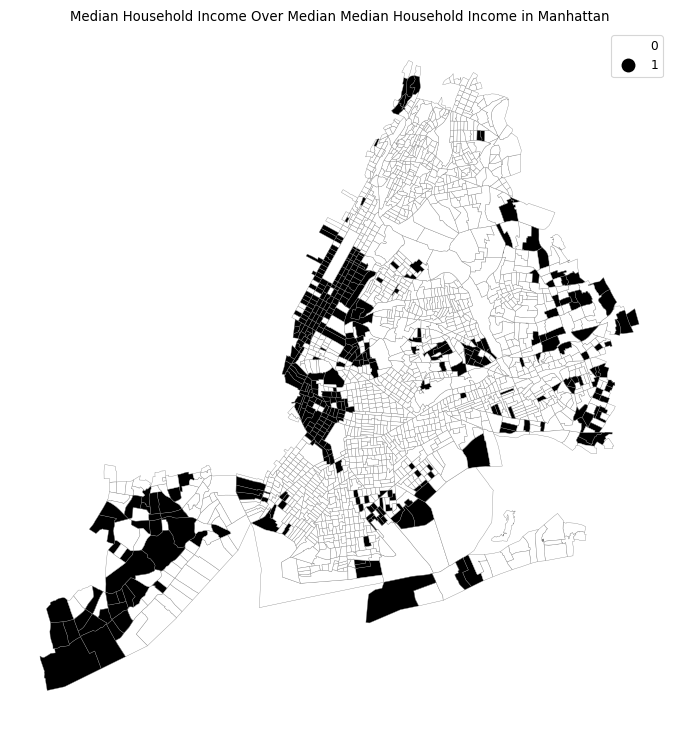

In [181]:
# using median median household income in Manhattan
f, ax = plt.subplots(1, figsize=(9, 9))
acs_data.plot(ax=ax,
              column="yb_mn",
              categorical=True,
              legend=True,
              edgecolor="0.5",
              linewidth=0.25,
              cmap="binary",
              figsize=(9, 9))

ax.set_axis_off()
ax.set_title("Median Household Income Over Median Median Household Income in Manhattan")
plt.show()

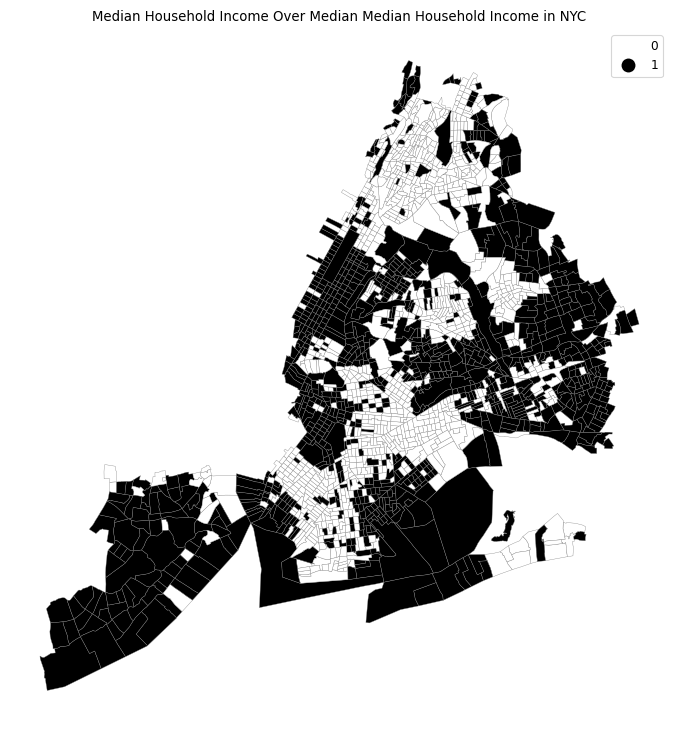

In [184]:
# using median of y
f, ax = plt.subplots(1, figsize=(9, 9))
acs_data.plot(ax=ax,
              column="yb",
              categorical=True,
              legend=True,
              edgecolor="0.5",
              linewidth=0.25,
              cmap="binary",
              figsize=(9, 9))

ax.set_axis_off()
ax.set_title("Median Household Income Over Median Median Household Income in NYC")
plt.show()

Do you think a binary map is better at showing spatial disparity than the quantile map in Q2.1? (2 pts)

The binary diagram is a simplified form of the quantile diagram to show spatial disparity more intuitively, as it provides two answers, True or False, by setting a "pass line". We can visually and directly see the locations where tend to exceed the median median household income. But it lacks the presentation of trends and centroids compared to quantile diagrams.

### 2.3 Moran's I (8 pts)
By looking at the maps, you are convinced that wealth is not distributed across NYC space evenly. Moran's I will provide you a statistical tool to further testify your hypothesis. 

To create a Moran Plot, you should first calculate the difference between the median household income and its mean. Then repeat the step for the spatial lags of the median household income. Add these two lists to **acs_data** as column *y_std* and *ylag_std*. (2 pts)
Then use seaborn module to make a scatter plot using the two columns. Add x and y axis names and tiles to the plot. (2 pts)

In [186]:
acs_data['y_std'] = (acs_data['y'] - acs_data['y'].mean())/acs_data['y'].std()
acs_data['ylag_std'] = (acs_data['ylag'] - acs_data['ylag'].mean())/acs_data['y'].std()

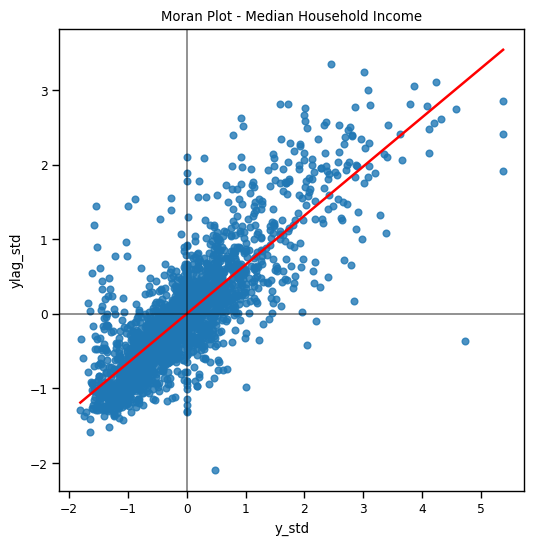

In [189]:
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(
                x="y_std",
                y="ylag_std",
                ci=None,
                data=acs_data,
                line_kws={"color": "r"},
                )
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - Median Household Income")
plt.show()

How do you interpret the Moran's Plot? Does it indicate a strong or weak autocorrelation? (2 pts)

The points on the graph are relatively clustered in the diagonal clustering from the lower left to the upper right, which indicates the existence of positive spatial autocorrelation, so the spatial autocorrelation is relatively strong.

What is the value of your Moran's I? (2 pts)

In [190]:
moran = esda.moran.Moran(acs_data['y'], wq)
moran.I

0.6594848030500569

### 2.4 Local Spatial Autocorrelation (8 pts)
The significant value of Moran's I confirms that the spatial distribution of NYC's wealth is highly uneven. But where are the richest neighborhoods and where are the poorest?

Firstly you can generate local Moran's I and name this variable as *li*. (2 pts)

In [191]:
li = esda.moran.Moran_Local(acs_data['y'], wq)

Based on the significance value (less than 0.05), create a new column *cl* to **acs_data** with values of *0 ns*, *1 hot pot*, *2 doughnut*, *3 cold spot*, and *4 diamond*. (2 pts)
As the names indicate, Hot Spot is the neighborhoods with high household income and Cold Spot is the neighborhoods with low household income. Doughnut is the low-income neighborhoods surrounded by high-income neighbors while Diamond is the high-income neighborhoods surrounded by low-income neighbors.

In [195]:
li.q

array([1, 1, 2, ..., 1, 1, 1])

In [197]:
counts = pd.value_counts(li.q)
counts
# Assign pseudo P-values to `db`
acs_data["p-sim"] = li.p_sim
# `1` if significant (at 5% confidence level), `0` otherwise
sig = 1 * (li.p_sim < 0.05)
# Assign significance flag to `db`
acs_data["sig"] = sig

In [200]:
# Pick as part of a quadrant only significant polygons,
# assign `0` otherwise (Non-significant polygons)
spots = li.q * sig
# Mapping from value to name (as a dict)
spots_labels = {
    0: "Non-Significant",
    1: "Hot Spot",
    2: "Doughnut",
    3: "Cold Spot",
    4: "Diamond",
}
# Create column in `db` with labels for each polygon
acs_data["cl"] = pd.Series(
    # First initialise a Series using values and `db` index
    spots,
    index=acs_data.index
    # Then map each value to corresponding label based
    # on the `spots_labels` mapping
).map(spots_labels)
# Print top for inspection
acs_data["cl"].head()

0           Hot Spot
1           Hot Spot
2    Non-Significant
3    Non-Significant
4           Hot Spot
Name: cl, dtype: object

In [201]:
acs_data["cl"].value_counts()

Non-Significant    1340
Cold Spot           422
Hot Spot            265
Doughnut             23
Diamond              16
Name: cl, dtype: int64

Plot the four types of census tracts with lightgrey to *0 ns*, red to *1 hot pot*, lightblue to *2 doughnut*, blue to *3 cold spot*, and pink to *4 diamond*. Add legend and titles to the plot. (2 pts)

In [282]:
cmap = {0: 'lightgray', 1: 'red', 2: 'lightblue', 3: 'blue', 4: 'pink'}

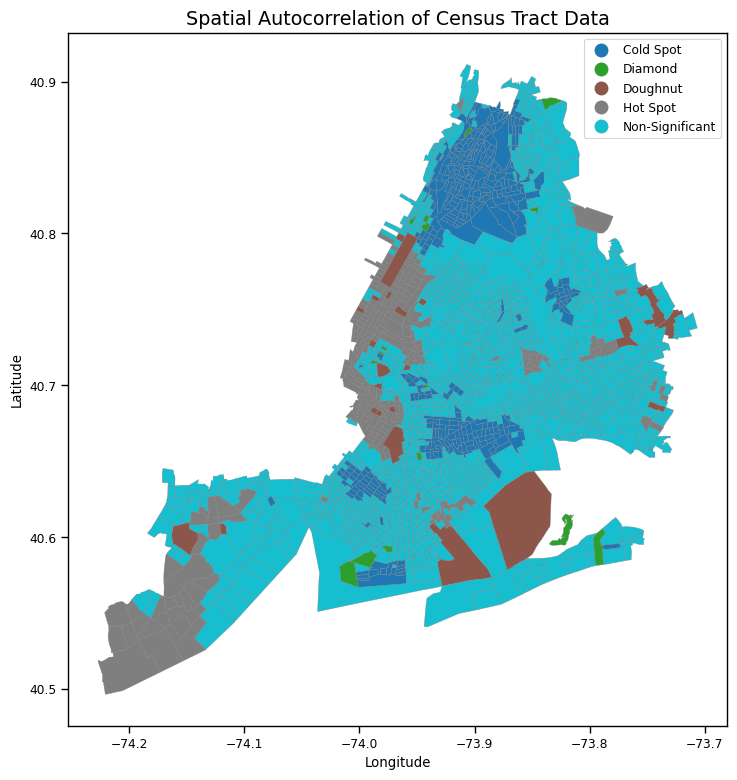

In [285]:
# using median of y
f, ax = plt.subplots(1, figsize=(9, 9))

acs_data.plot(ax=ax,
              column='cl',
              categorical=True,
              legend=True,
              edgecolor="0.5",
              linewidth=0.25,
              figsize=(9, 9))


ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Spatial Autocorrelation of Census Tract Data', fontsize='x-large')

plt.show()

How do you interpret the four types of colored regions under the NYC context? Why do some parks apprear as "doughnuts"? (2 pts)

The majority parts of NYC has no statistically significant difference from the mean for household income. The Bronx is an obvious cold spot as it's relevently far from Manhattan, where things happen and is a hot spot. 
Since the park is uninhabited, there will be very low, even 0 median household income. therefore, it is easy to reach a doughnut when they are compared with neighboring areas.

### 2.5 Point Pattern Analysis (18 pts)
With an image of wealth distribution across NYC, now you can move to the Airbnb listing to see if locations of the short-term rental listing have any relationship with their neighborhoods.

Map all the listing in Manhattan by their coordinates and show the density on latitudes and longitudes respectively. (2 pts)

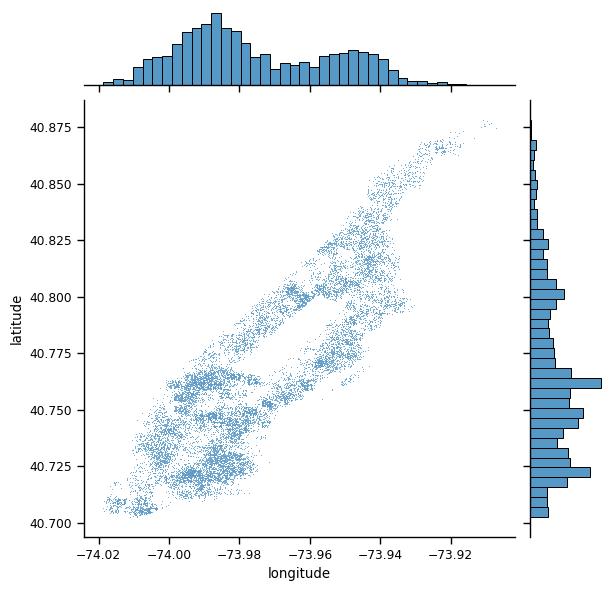

In [234]:
listing_mn = listing[listing['boroname'] == 'Manhattan']
sns.jointplot(x="longitude", 
              y="latitude", 
              data=listing_mn, 
              s=0.5)

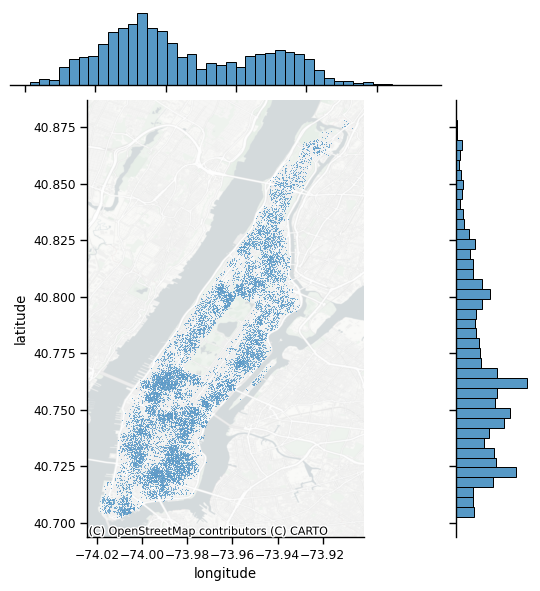

In [260]:
listing_mn = listing[listing['boroname'] == 'Manhattan']
joint_axes = sns.jointplot(x="longitude", 
                           y="latitude", 
                           data=listing_mn, 
                           s=0.5)

ctx.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=ctx.providers.CartoDB.PositronNoLabels
);

To generate a density map for points data, you should firstly assign those points to different areal units. Hexagon is one of the most used units. For Manhattan, you can generate and add hexbin with 50 hexagons in each dimension without bordorline and with half transparency. (2 pts) Add a base map and colorbar and remove axes. (2 pts) Show your map below.

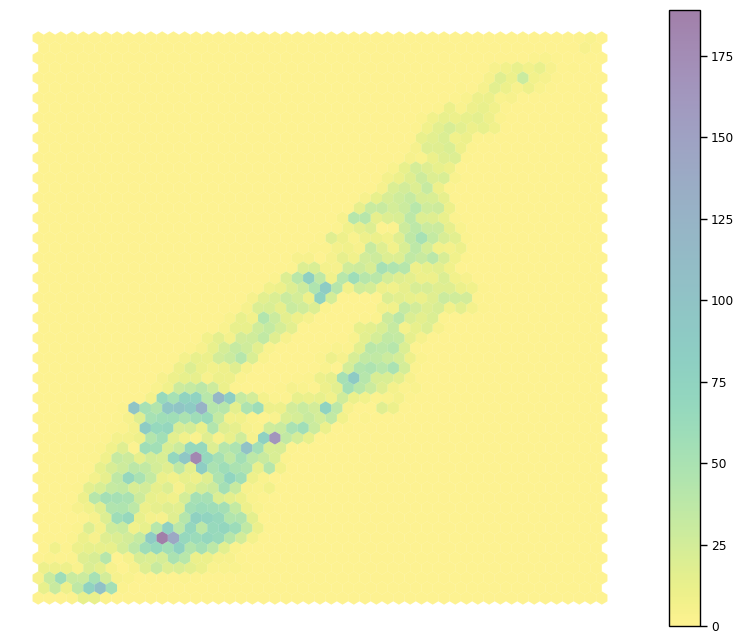

In [265]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(10, 8))
# Generate and add hexbin with 50 hexagons in each
# dimension, no borderlines, half transparency,
# and the reverse viridis colormap
hb = ax.hexbin(
    listing_mn["longitude"],
    listing_mn["latitude"],
    gridsize=50,
    linewidths=0,
    alpha=0.5,
    cmap="viridis_r",
)
# Add basemap
ctx.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=ctx.providers.CartoDB.PositronNoLabels
)
# Add colorbar
plt.colorbar(hb)
# Remove axes
ax.set_axis_off()

Find out the mean center (2 pts), median center (2 pts) and standardized ellipse of the Manhattan Airbnb listing. Legend and axis names should be added.

In [256]:
import numpy
import pandas as pd
import geopandas as gpd
import pysal

import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx

sns.set_context(context='paper')

from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

from sklearn.cluster import DBSCAN

import warnings

warnings.filterwarnings("ignore")

from pointpats import centrography
from matplotlib.patches import Ellipse

In [257]:
mean_center = centrography.mean_center(listing_mn[["longitude","latitude"]])
med_center = centrography.euclidean_median(listing_mn[["longitude","latitude"]])
major, minor, rotation = centrography.ellipse(listing_mn[["longitude","latitude"]])

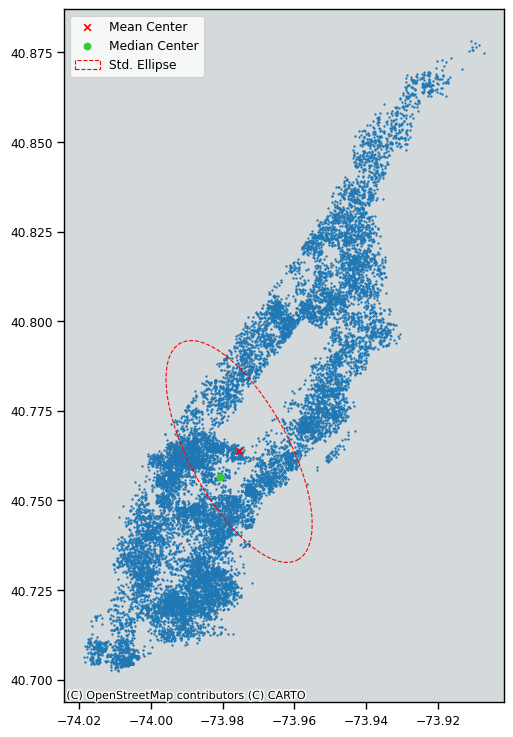

In [258]:
from matplotlib.patches import Ellipse

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot photograph points
ax.scatter(listing_mn["longitude"],listing_mn["latitude"], s=0.75)
ax.scatter(*mean_center, color="red", marker="x", label="Mean Center")
ax.scatter(
    *med_center, color="limegreen", marker="o", label="Median Center"
)

# Construct the standard ellipse using matplotlib
ellipse = Ellipse(
    xy=mean_center,  # center the ellipse on our mean center
    width=major * 2,  # centrography.ellipse only gives half the axis
    height=minor * 2,
    angle=numpy.rad2deg(
        rotation
    ),  # Angles for this are in degrees, not radians
    facecolor="none",
    edgecolor="red",
    linestyle="--",
    label="Std. Ellipse",
)
ax.add_patch(ellipse)

ax.legend()
# Display
# Add basemap
ctx.add_basemap(
    ax, source=ctx.providers.CartoDB.Positron
)
plt.show()

Why do the mean and median centers differ? (2 pts)

The discrepancy between the two centers is caused by the skew; there are many "clusters" of lower values of pictures far out in uptown Manhattan, whereas downtown and midtown, before the central park, is densely packed, but drops off very quickly. Thus, the far out clusters of pictures pulls the mean center to the north and east, relative to the median center.

Generate a quadrat count map based on the listing. In each quadrat, the number of listings should be shown. (2 pts)

In [267]:
from pointpats import (
    distance_statistics,
    QStatistic,
    random,
    PointPattern,
)

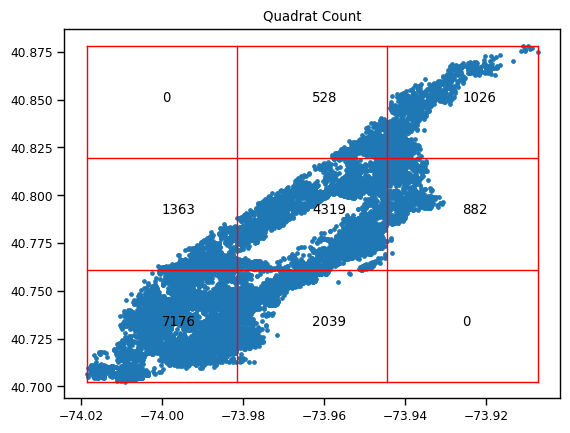

In [272]:
qstat = QStatistic(listing_mn[["longitude","latitude"]].values)
qstat.plot()

From the Quadrat Count figure, which areas have the densest Airbnbs? Provide some hypotheses for why this might be the case. (2 pts)

Downtown and midtown Manhattan, before the central park, defently has the densest Airbnbs. Some possible hypotheses are:
    1. There are many vistors tend to live close to famous placess to visit, such as Times Square，Wall street, etc, that are all gather in downtown and midtown Manhattan.
    2. This area has the most options of public transit. Majority area is covered under walk distance to subway stations and has muliple lines. 
    3. Most importantly, comparing to other quadrats, this area has the largest area of land counted.

What is the p-value of a chi-squared test? How do you interpret the value? (2 pts)

In [273]:
qstat.chi2_pvalue

0.0

A p-value of 0 for a chi-squared test means that the observed data is extremely unlikely under the null hypothesis. This would suggest that there is a very strong association between the variables being studied, and that the null hypothesis can be rejected with a high degree of confidence. 